# 20230511 - Determining region level clustering 

1. Calculate lobm scargle on padded regions with known assignments
2. Total power per joint within region (proboscis, locomotion, idle, etc)
* Bar graph for total power
* Threshold for things that aren’t actually moving

3. Threshold each node (Slack)
4. All by all distance claculation (frame by frame)
* Normalized but thresholded
* Unnormalized but thresholded
* Unnormalized no threshold

5. Generate distance matrix
* Distance matrix with dendrogram

In [1]:
import os
import h5py
import numpy as np
from scipy.io import loadmat
import logging

# Setting up proper logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())


# Directory containing the h5 files
data_dir = "/Genomics/ayroleslab2/scott/git/lts-manuscript/analysis/20230507-mmpy-lts-all-pchip5-headprobinterp-medianwin5-gaussian-lombscargle-win50-singleflysampledtracks/Projections"


# Load behavior mapping
behavior_mapping_path = "/Genomics/ayroleslab2/scott/git/lts-manuscript/analysis/notebooks/data/behav_ind.h5"
behavior_mapping = h5py.File(behavior_mapping_path)["inds"][:].T#loadmat(behavior_mapping_path)['behav_ind']  # replace 'behav_ind' with the actual variable name in the .mat file
behavior_mapping = behavior_mapping.astype(int)
# Dictionary to map behavior indices to their names
behavior_dict = {1: 'idle', 2: 'loco', 3: 'proboscis', 4: 'fore_groom', 5: 'hind_groom'}


In [2]:
# Initialize a dictionary to count the number of frames for each behavior
frame_counts = {}

# Loop through each row in the behavior mapping
for row in behavior_mapping:
    flid, samp, startframe, endframe, behavior = map(int, row)
    behavior = behavior_dict[behavior]

    # Add the number of frames for this row to the running total for this behavior
    frame_counts[behavior] = frame_counts.get(behavior, 0) + (endframe - startframe)

logger.info(f"Total number of frames for each behavior: {frame_counts}")

Total number of frames for each behavior: {'idle': 340, 'loco': 370, 'proboscis': 750, 'fore_groom': 560, 'hind_groom': 390}


In [3]:
from tqdm import tqdm

behavior_projections = {}

# Loop through each row in the behavior mapping -- wrapped in tqdm for a progress bar
for i, row in tqdm(enumerate(behavior_mapping)):
    flid, samp, startframe, endframe, behavior = map(int, row)
    behavior = behavior_dict[behavior]

    # Construct the filename from flid and samp
    filename = f"flid_{flid}samp_{samp}-pcaModes.mat"

    # Open the h5 file
    with h5py.File(os.path.join(data_dir, filename), 'r') as f:
        
        # Read the 'projections' data for the specified frames
        # Note that this doesn't deal with frames at the beginning or end of the file for now
        proj_shape = f['projections'].shape
        projections = np.array(f['projections'][:,max(0,startframe-320):min(proj_shape[1],endframe+320)])

    # Store the projections data in the dictionary,
    # first level keys are behaviors, second level keys are (flid, samp) tuples
    if behavior not in behavior_projections:
        behavior_projections[behavior] = {}
    behavior_projections[behavior][i] = projections
    # Find number of flies and samples for each behavior


50it [00:00, 61.61it/s]


In [4]:
# Find number of flies and samples for each behavior
for behavior in behavior_projections:
    logger.info(f"Number of flies and samples for behavior {behavior}: {len(behavior_projections[behavior])}")

Number of flies and samples for behavior idle: 10
Number of flies and samples for behavior loco: 10
Number of flies and samples for behavior proboscis: 10
Number of flies and samples for behavior fore_groom: 10
Number of flies and samples for behavior hind_groom: 10


In [5]:
import multiprocessing as mp
import numpy as np
import time
from scipy.signal import lombscargle

In [6]:

def mm_findWavelets_ls(projections, parameters):
    t1 = time.time()
    # print("\t Calculating wavelets, clock starting.")
    
    # print("Using Lomb-Scargle.")

    projections = np.array(projections)
    
    t1 = time.time()

    minT = 1.0 / parameters.maxF
    maxT = 1.0 / parameters.minF
    Ts = minT * (
        2
        ** (
            (np.arange(parameters.numPeriods) * np.log(maxT / minT))
            / (np.log(2) * (parameters.numPeriods - 1))
        )
    )
    f = (1.0 / Ts)[::-1]

    omega0 = 20
    samplingFreq = 100
    
    scales = (omega0 + np.sqrt(2 + omega0**2)) / (4 * np.pi * f)
    window_sizes = np.round(scales * samplingFreq).astype(int)
    # print(f"Window sizes: {window_sizes}")
    # print(f"Frequencies: {f}, shape: {f.shape}")

    N = projections.shape[0]
    # print(f"Projection shape: {projections.shape}")
    try:
        pool = mp.Pool(parameters.numProcessors)
        # print(f"Scarglin' {projections.shape[1]} projections")
        amplitudes = pool.starmap(
            rolling_lombscargle,
            [
                (
                    projections[:, i],
                    np.linspace(0, N / parameters.samplingFreq, N),
                    f.astype(float),
                    window_sizes,
                )
                for i in range(projections.shape[1])
            ],
        )
        amplitudes = np.concatenate(amplitudes, 0)
        amplitudes[~np.isfinite(amplitudes)] = 0
        # print(f"Done Scarglin' -- shape: {amplitudes.shape}")
        pool.close()
        pool.join()
    except Exception as E:
        pool.close()
        pool.join()
        raise E
    # print("\t Done at %0.02f seconds." % (time.time() - t1))
    return amplitudes.T, f, window_sizes


def rolling_window_with_padding(arr, window_size):
    padding = (window_size - 1) // 2
    padded_arr = np.pad(arr, (padding, padding), mode="edge")
    shape = padded_arr.shape[:-1] + (
        padded_arr.shape[-1] - window_size + 1,
        window_size,
    )
    strides = padded_arr.strides + (padded_arr.strides[-1],)

    return np.lib.stride_tricks.as_strided(padded_arr, shape=shape, strides=strides)


def rolling_lombscargle(data, sampling_times, freqs, window_sizes):

    # Initialize an empty array to store the Lomb-Scargle periodograms
    periodograms = np.zeros((data.size, freqs.size))

    for f_idx, (freq, window_size) in enumerate(zip(freqs, window_sizes)):
        windows = rolling_window_with_padding(data, window_size)

        windows_sampling_times = rolling_window_with_padding(
            sampling_times, window_size
        )

        for i, (window, times) in enumerate(zip(windows, windows_sampling_times)):
            angular_frequency = 2 * np.pi * freq
            tmp_window = window.copy()
            # print(f"Inside rolling_lombscargle -  window shape: {window.shape}")
            window = window[np.isfinite(tmp_window)]
            # print(f"Post nan removal -  window shape: {window.shape}")
            # sampling_times = sampling_times[np.isfinite(tmp_window)]
            sampling_times_window = times[np.isfinite(tmp_window)]
            # print(f"Processing window {i} of {windows.shape[0]}")
            periodogram = lombscargle(
                sampling_times_window,
                window,
                [angular_frequency],
                # normalize=True,
                # precenter=True,
            )

            if np.all(np.isnan(periodogram)):
                periodogram = 0

            periodograms[i, f_idx] = periodogram
    return periodograms.T


In [7]:
%%capture

class Parameters:
    def __init__(self, samplingFreq, maxF, minF, numPeriods, numProcessors, numModes):
        self.samplingFreq = samplingFreq
        self.maxF = maxF
        self.minF = minF
        self.numPeriods = numPeriods
        self.numProcessors = numProcessors
        self.numModes = numModes

parameters = Parameters(100, 50, 1, 25, 24, 25)


wavelet_results = {}

# Now apply the wavelet function to each projection
for behavior, flid_samp_projections in behavior_projections.items():
    behavior_wavelets = {}
    logger.info(f"Processing behavior: {behavior} -- {len(flid_samp_projections)} samples")

    for flid_samp, projections in flid_samp_projections.items():
        projections = projections.T
        logger.info(f"Shape of projections: {projections.shape}")
        wavelet, freqs, window_sizes = mm_findWavelets_ls(projections, parameters)
        # logger.info(f"Processing behavior: {behavior} -- {flid_samp} -- {wavelet.shape} -- {projections.shape}")
        wavelet = wavelet[320:-320,:]
        behavior_wavelets[flid_samp] = wavelet
        
    wavelet_results[behavior] = behavior_wavelets

Processing behavior: idle -- 10 samples
Shape of projections: (674, 24)
Shape of projections: (674, 24)
Shape of projections: (674, 24)
Shape of projections: (674, 24)
Shape of projections: (674, 24)
Shape of projections: (674, 24)
Shape of projections: (674, 24)
Shape of projections: (674, 24)
Shape of projections: (674, 24)
Shape of projections: (674, 24)
Processing behavior: loco -- 10 samples
Shape of projections: (669, 24)
Shape of projections: (669, 24)
Shape of projections: (669, 24)
Shape of projections: (669, 24)
Shape of projections: (669, 24)
Shape of projections: (669, 24)
Shape of projections: (689, 24)
Shape of projections: (689, 24)
Shape of projections: (689, 24)
Shape of projections: (689, 24)
Processing behavior: proboscis -- 10 samples
Shape of projections: (709, 24)
Shape of projections: (709, 24)
Shape of projections: (709, 24)
Shape of projections: (709, 24)
Shape of projections: (709, 24)
Shape of projections: (709, 24)
Shape of projections: (709, 24)
Shape of pr

### Window size

Window sizes: [319 271 230 195 166 141 120 102  87  73  62  53  45  38  33  28  23  20
  17  14  12  10   9   8   6]

### Frequencies going in
Frequencies: [ 1. 1.17703782  1.38541802  1.63068941  1.9193831   2.2591865
  2.65914795  3.1299177   3.6840315   4.3362444   5.10392364  6.00751115
  7.07106781  8.32291423  9.7963848  11.53071539 13.57208808 15.97486094
 18.80301547 22.13186029 26.05003655 30.66187818 36.09019018 42.4795187
 50.], shape: (25,)

In [8]:
total_frames_per_behavior = {}

for behavior, flid_samp_wavelets in wavelet_results.items():
    total_frames = sum([wavelet.shape[0] for wavelet in flid_samp_wavelets.values()])
    total_frames_per_behavior[behavior] = total_frames


# Now we can calculate the average wavelet for each behavior

logger.info(f"Total number of frames for each behavior -- wavelets: {total_frames_per_behavior}")

logger.info(f"Total number of frames for each behavior -- projections: {frame_counts}")

Total number of frames for each behavior -- wavelets: {'idle': 340, 'loco': 370, 'proboscis': 750, 'fore_groom': 560, 'hind_groom': 390}
Total number of frames for each behavior -- projections: {'idle': 340, 'loco': 370, 'proboscis': 750, 'fore_groom': 560, 'hind_groom': 390}


In [9]:
average_total_power_per_node = {}

# Iterate over each behavior
for behavior, behavior_wavelets in wavelet_results.items():
    logger.info(f"Aggregating wavelets for behavior {behavior}")
    wlets = np.concatenate(list(behavior_wavelets.values()), axis=0)
    wlets = np.abs(wlets) ** 2  # Power
    # wlets[wlets < 1e7] = 0 # Thresholding
    
    total_power_per_node = []

    # Calculate power per node for each set of wavelets
    for wavelet in behavior_wavelets.values():
        power = np.abs(wavelet)# ** 2

        # Sum over the frames axis (0th dimension, as power shape is (frames, nodes*freqs))
        total_power = np.sum(power, axis=0)
        
        # Reshape to separate node and frequency dimensions (assuming number of nodes is 24 and freqs is 25)
        total_power = total_power.reshape(-1, 2, 25)

        # Sum over the frequency axis to get total power per node
        total_power_per_node.append(np.sum(total_power, axis=2))

    # Average over all wavelet sets for the behavior
    average_total_power = np.mean(total_power_per_node, axis=0)

    average_total_power_per_node[behavior] = average_total_power

Aggregating wavelets for behavior idle
Aggregating wavelets for behavior loco
Aggregating wavelets for behavior proboscis
Aggregating wavelets for behavior fore_groom
Aggregating wavelets for behavior hind_groom


In [10]:
example_file = "/Genomics/ayroleslab2/scott/long-timescale-behavior/data/organized_tracks/20220217-lts-cam1/cam1_20220217_0through190_cam1_20220217_0through190_100-tracked.analysis.h5"
with h5py.File(example_file, "r") as f:
    node_names = [n.decode() for n in f["node_names"][:]]

node_names = [n for n in node_names if n not in ["thorax", "head"]]
node_names = np.repeat(node_names, 2)

logger.info(f"Node names: {node_names}")

Node names: ['eyeL' 'eyeL' 'eyeR' 'eyeR' 'abdomen' 'abdomen' 'forelegL' 'forelegL'
 'forelegR' 'forelegR' 'midlegL' 'midlegL' 'midlegR' 'midlegR' 'hindlegL'
 'hindlegL' 'hindlegR' 'hindlegR' 'wingL' 'wingL' 'wingR' 'wingR'
 'proboscis' 'proboscis']


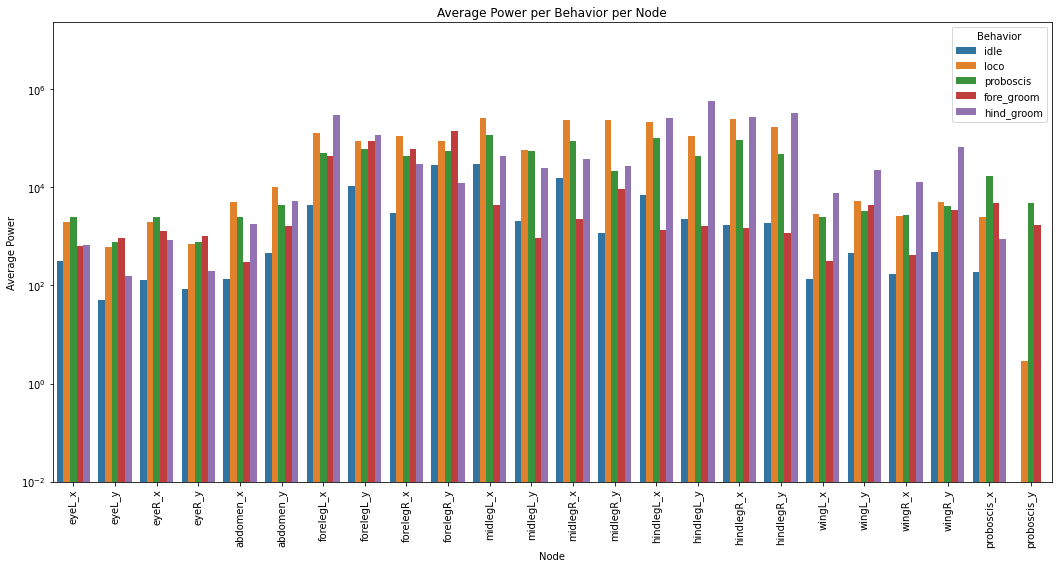

In [11]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Node names
node_names = ['eyeL_x', 'eyeL_y', 'eyeR_x', 'eyeR_y', 'abdomen_x', 'abdomen_y', 'forelegL_x', 'forelegL_y', 'forelegR_x', 'forelegR_y', 'midlegL_x',
              'midlegL_y', 'midlegR_x', 'midlegR_y', 'hindlegL_x', 'hindlegL_y', 'hindlegR_x', 'hindlegR_y', 'wingL_x', 'wingL_y', 'wingR_x', 'wingR_y', 'proboscis_x', 'proboscis_y']

# Prepare data for seaborn
data = []
for behavior, powers in average_total_power_per_node.items():
    for node_name, power in zip(node_names, powers.flatten()):
        data.append([behavior, node_name, power])

df = pd.DataFrame(data, columns=["Behavior", "Node", "Average Power"])

# Plot
plt.figure(figsize=(15, 8))
sns.barplot(data=df, x="Node", y="Average Power", hue="Behavior")
plt.title('Average Power per Behavior per Node')
plt.ylabel('Average Power')
plt.xlabel('Node')
plt.xticks(rotation=90)
plt.tight_layout()
plt.yscale('log')
plt.ylim(1e-2)
plt.savefig('figures/power_per_behavior_per_node.jpg')
plt.show()


In [12]:
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# Assuming wavelet_results is your dict with behavior as key and wavelets (N, 600) as value
# Assuming freqs is your list of frequencies
# Assuming wlet_nodes is your list of node names

figures_path = Path("figures/fingerprints/ls-behavior-signatures/")
figures_path.mkdir(parents=True, exist_ok=True)

for behavior, behavior_wavelets in tqdm(wavelet_results.items()):
    wlets = np.concatenate(list(behavior_wavelets.values()), axis=0)
    print(f"Plotting behavior {behavior}")
    power = np.abs(wlets) #** 2
    # power[power < 1e7] = 0
    mean_amps = np.mean(power, axis=0)  # compute power spectrum
    split_to_nodes = np.array_split(mean_amps, 24)
    resulting_numpy = np.zeros((24, 25))
    for i, node_mean_amps in enumerate(split_to_nodes):
        resulting_numpy[i, :] = node_mean_amps
    fig, ax = plt.subplots(figsize=(10, 5))
    im = ax.imshow(resulting_numpy, aspect="auto")
    ax.set_xticks([0, 5, 10, 15, 20, 24])
    ax.set_xticklabels(["%0.1f" % freqs[j] for j in [0, 5, 10, 15, 20, 24]])
    ax.set_yticks(np.arange(24))
    ax.set_yticklabels([node_names[j] for j in np.arange(24)])
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Power Spectrum')
    # cbar.set_ticks(np.linspace(0, 1, num=5))
    cbar.set_ticklabels(['{:.2E}'.format(10 ** tick) for tick in np.linspace(np.log10(resulting_numpy.min()), np.log10(resulting_numpy.max()), num=10)])
    fig.savefig(
        figures_path / f"behavior-{behavior}-wavelet-example-by-part.png",
        dpi=600,
        bbox_inches="tight",
    )
    plt.close()


  0%|          | 0/5 [00:00<?, ?it/s]/Genomics/argo/users/swwolf/.conda/envs/sleap_dev/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator


Plotting behavior idle


 20%|██        | 1/5 [00:01<00:07,  1.96s/it]

Plotting behavior loco


 40%|████      | 2/5 [00:03<00:05,  1.94s/it]

Plotting behavior proboscis


 60%|██████    | 3/5 [00:05<00:03,  1.95s/it]

Plotting behavior fore_groom


 80%|████████  | 4/5 [00:07<00:01,  1.98s/it]

Plotting behavior hind_groom


100%|██████████| 5/5 [00:09<00:00,  1.98s/it]


In [13]:
import pickle
pickle.dump(wavelet_results, open("data/wavelet_results.pickle", "wb"))